# Illustrating the von Mises-Fisher distribution

*Final Project MVA Computational Statistics course 2022-2023*


In [ ]:
import numpy as np
from scipy.linalg import null_space
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy.matlib
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

In [ ]:
import matplotlib

In [ ]:
matplotlib.rcParams["figure.dpi"] = 300

In [ ]:
def rand_uniform_hypersphere(N,p):
    
    """ 
        rand_uniform_hypersphere(N,p)
        =============================
    
        Generate random samples from the uniform distribution on the (p-1)-dimensional 
        hypersphere $\mathbb{S}^{p-1} \subset \mathbb{R}^{p}$. We use the method by 
        Muller [1], see also Ref. [2] for other methods.
        
        INPUT:  
        
            * N (int) - Number of samples 
            * p (int) - The dimension of the generated samples on the (p-1)-dimensional hypersphere.
                - p = 2 for the unit circle $\mathbb{S}^{1}$
                - p = 3 for the unit sphere $\mathbb{S}^{2}$
            Note that the (p-1)-dimensional hypersphere $\mathbb{S}^{p-1} \subset \mathbb{R}^{p}$ and the 
            samples are unit vectors in $\mathbb{R}^{p}$ that lie on the sphere $\mathbb{S}^{p-1}$.
    
    References:
    
    [1] Muller, M. E. "A Note on a Method for Generating Points Uniformly on N-Dimensional Spheres."
    Comm. Assoc. Comput. Mach. 2, 19-20, Apr. 1959.
    
    [2] https://mathworld.wolfram.com/SpherePointPicking.html
    
    """
    
    if (p<=0) or (type(p) is not int):
        raise Exception("p must be a positive integer.")
    
    # Check N>0 and is an int
    if (N<=0) or (type(N) is not int):
        raise Exception("N must be a non-zero positive integer.")
    
    v = np.random.normal(0,1,(N,p))
    
#    for i in range(N):
#        v[i,:] = v[i,:]/np.linalg.norm(v[i,:])
        
    v = np.divide(v,np.linalg.norm(v,axis=1,keepdims=True))
    
    return v

In [ ]:
def rand_t_marginal(kappa,p,N=1):
    """
        rand_t_marginal(kappa,p,N=1)
        ============================
        
        Samples the marginal distribution of t using rejection sampling of Wood [3]. 
    
        INPUT: 
        
            * kappa (float) - concentration        
            * p (int) - The dimension of the generated samples on the (p-1)-dimensional hypersphere.
                - p = 2 for the unit circle $\mathbb{S}^{1}$
                - p = 3 for the unit sphere $\mathbb{S}^{2}$
            Note that the (p-1)-dimensional hypersphere $\mathbb{S}^{p-1} \subset \mathbb{R}^{p}$ and the 
            samples are unit vectors in $\mathbb{R}^{p}$ that lie on the sphere $\mathbb{S}^{p-1}$.
            * N (int) - number of samples 
        
        OUTPUT: 
        
            * samples (array of floats of shape (N,1)) - samples of the marginal distribution of t
    """
    
    # Check kappa >= 0 is numeric 
    if (kappa < 0) or ((type(kappa) is not float) and (type(kappa) is not int)):
        raise Exception("kappa must be a non-negative number.")
        
    if (p<=0) or (type(p) is not int):
        raise Exception("p must be a positive integer.")
    
    # Check N>0 and is an int
    if (N<=0) or (type(N) is not int):
        raise Exception("N must be a non-zero positive integer.")
    
    
    # Start of algorithm 
    b = (p - 1.0) / (2.0 * kappa + np.sqrt(4.0 * kappa**2 + (p - 1.0)**2 ))    
    x0 = (1.0 - b) / (1.0 + b)
    c = kappa * x0 + (p - 1.0) * np.log(1.0 - x0**2)
    
    samples = np.zeros((N,1))
    
    # Loop over number of samples 
    for i in range(N):
        
        # Continue unil you have an acceptable sample 
        while True: 
            
            # Sample Beta distribution
            Z = np.random.beta( (p - 1.0)/2.0, (p - 1.0)/2.0 )
            
            # Sample Uniform distribution
            U = np.random.uniform(low=0.0,high=1.0)
            
            # W is essentially t
            W = (1.0 - (1.0 + b) * Z) / (1.0 - (1.0 - b) * Z)
            
            # Check whether to accept or reject 
            if kappa * W + (p - 1.0)*np.log(1.0 - x0*W) - c >= np.log(U):
                
                # Accept sample
                samples[i] = W
                break
                          
    return samples

In [ ]:
def rand_von_mises_fisher(mu,kappa,N=1):
    """
        rand_von_mises_fisher(mu,kappa,N=1)
        ===================================
        
        Samples the von Mises-Fisher distribution with mean direction mu and concentration kappa. 
        
        INPUT: 
        
            * mu (array of floats of shape (p,1)) - mean direction. This should be a unit vector.
            * kappa (float) - concentration. 
            * N (int) - Number of samples. 
        
        OUTPUT: 
        
            * samples (array of floats of shape (N,p)) - samples of the von Mises-Fisher distribution
            with mean direction mu and concentration kappa. 
    """
    
    
    # Check that mu is a unit vector
    eps = 10**(-8) # Precision 
    norm_mu = np.linalg.norm(mu)
    if abs(norm_mu - 1.0) > eps:
        raise Exception("mu must be a unit vector.")
        
    # Check kappa >= 0 is numeric 
    if (kappa < 0) or ((type(kappa) is not float) and (type(kappa) is not int)):
        raise Exception("kappa must be a non-negative number.")
    
    # Check N>0 and is an int
    if (N<=0) or (type(N) is not int):
        raise Exception("N must be a non-zero positive integer.")
    
    # Dimension p
    p = len(mu)
    
    # Make sure that mu has a shape of px1
    mu = np.reshape(mu,(p,1))
    
    # Array to store samples 
    samples = np.zeros((N,p))
    
    #  Component in the direction of mu (Nx1)
    t = rand_t_marginal(kappa,p,N) 
    
    # Component orthogonal to mu (Nx(p-1))
    xi = rand_uniform_hypersphere(N,p-1) 
   
    # von-Mises-Fisher samples Nxp
    
    # Component in the direction of mu (Nx1).
    # Note that here we are choosing an 
    # intermediate mu = [1, 0, 0, 0, ..., 0] later
    # we rotate to the desired mu below
    samples[:,[0]] = t 
    
    # Component orthogonal to mu (Nx(p-1))
    samples[:,1:] = np.matlib.repmat(np.sqrt(1 - t**2), 1, p-1) * xi
    
    # Rotation of samples to desired mu
    O = null_space(mu.T)
    R = np.concatenate((mu,O),axis=1)
    samples = np.dot(R,samples.T).T
    
    return samples


In [ ]:
def plot_3d_scatter(data,ax=None,colour='red',sz=30,el=20,az=50,sph=True,sph_colour="gray",sph_alpha=0.03,
                    eq_line=True,pol_line=True,grd=False):
    """
        plot_3d_scatter()
        =================
        
        Plots 3D samples on the surface of a sphere.
        
        INPUT: 
        
            * data (array of floats of shape (N,3)) - samples of a spherical distribution such as von Mises-Fisher.
            * ax (axes) - axes on which the plot is constructed.
            * colour (string) - colour of the scatter plot.
            * sz (float) - size of points.
            * el (float) - elevation angle of the plot.
            * az (float) - azimuthal angle of the plot.
            * sph (boolean) - whether or not to inclde a sphere.
            * sph_colour (string) - colour of the sphere if included.
            * sph_alpha (float) - the opacity/alpha value of the sphere.
            * eq_line (boolean) - whether or not to include an equatorial line.
            * pol_line (boolean) - whether or not to include a polar line.
            * grd (boolean) - whether or not to include a grid.
            
        OUTPUT: 
        
            * ax (axes) - axes on which the plot is contructed. 
            * Plot of 3D samples on the surface of a sphere. 
            
    """
    
    
    # The polar axis
    if ax is None:
        ax = plt.axes(projection='3d')
        
    # Check that data is 3D (data should be Nx3)
    d = np.shape(data)[1]
    if d != 3: 
        raise Exception("data should be of shape Nx3, i.e., each data point should be 3D.")
        
    ax.scatter(data[:,0],data[:,1],data[:,2],s=5,c=colour)
    ax.view_init(el, az)
    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-1.5,1.5)
    ax.set_zlim(-1.5,1.5)
    
    # Add a shaded unit sphere
    if sph:
        u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:30j]
        x = np.cos(u)*np.sin(v)
        y = np.sin(u)*np.sin(v)
        z = np.cos(v)
        ax.plot_surface(x, y, z, color=sph_colour,alpha=sph_alpha)
    
    # Add an equitorial line 
    if eq_line: 
        # t = theta, p = phi
        eqt = np.linspace(0,2*np.pi,50,endpoint=False)
        eqp = np.linspace(0,2*np.pi,50,endpoint=False)
        eqx = 2*np.sin(eqt)*np.cos(eqp) 
        eqy = 2*np.sin(eqt)*np.sin(eqp) - 1
        eqz = np.zeros(50)
        
        # Equator line
        ax.plot(eqx,eqy,eqz,color="k",lw=1)
       
    # Add a polar line 
    if pol_line: 
        # t = theta, p = phi
        eqt = np.linspace(0,2*np.pi,50,endpoint=False)
        eqp = np.linspace(0,2*np.pi,50,endpoint=False)
        eqx = 2*np.sin(eqt)*np.cos(eqp) 
        eqy = 2*np.sin(eqt)*np.sin(eqp) - 1
        eqz = np.zeros(50)
        
        # Polar line
        ax.plot(eqx,eqz,eqy,color="k",lw=1)
        
    # Draw a centre point
    ax.scatter([0], [0], [0], color="k", s=sz)    
        
    # Turn off grid 
    ax.grid(grd)
    
    # Ticks 
    ax.set_xticks([-1,0,1])
    ax.set_yticks([-1,0,1])
    ax.set_zticks([-1,0,1])
    
    return ax

In [ ]:
# Drawing a fancy vector see Ref. [7] 
class Arrow3D(FancyArrowPatch):

    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)
        
def plot_arrow(point,ax,colour="red"):
    """
        plot_arrow(point,ax,colour="red")
        ==============================
        
        Plots a 3D arrow on the axes ax from the origin to the point mu. 
        
        INPUT: 
        
            * point (array of floats of shape (3,1)) - a 3D point.
            * ax (axes) - axes on which the plot is constructed.
            * colour (string) - colour of the arrow.
        
    """
    
    # Can use quiver for a simple arrow
    #ax.quiver(0,0,0,point[0],point[1],point[2],length=1.0,color=colour,pivot="tail")
    
    # Fancy arrow 
    a = Arrow3D([0, point[0]], [0, point[1]], [0, point[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color=colour)
    ax.add_artist(a)
    
    return ax

In [ ]:
# All sets have the same number of data points 
Nsim = 2000

# Set 1
mu1 = [0,0,1]
mu1 = mu1/np.linalg.norm(mu1)
kappa1 = 0
data1 = rand_von_mises_fisher(mu1,kappa=kappa1,N=Nsim)

# Set 2
mu1 = [0,0,1]
mu1 = mu1/np.linalg.norm(mu1)
kappa2 = 10
data2 = rand_von_mises_fisher(mu1,kappa=kappa2,N=Nsim)

# Set 3 
mu1 = [0,0,1]
mu1 = mu1/np.linalg.norm(mu1)
kappa3 = 100
data3 = rand_von_mises_fisher(mu1,kappa=kappa3,N=Nsim)

In [ ]:
fs=16

In [ ]:
import matplotlib.style as style
style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [ ]:
style.use('seaborn-poster')

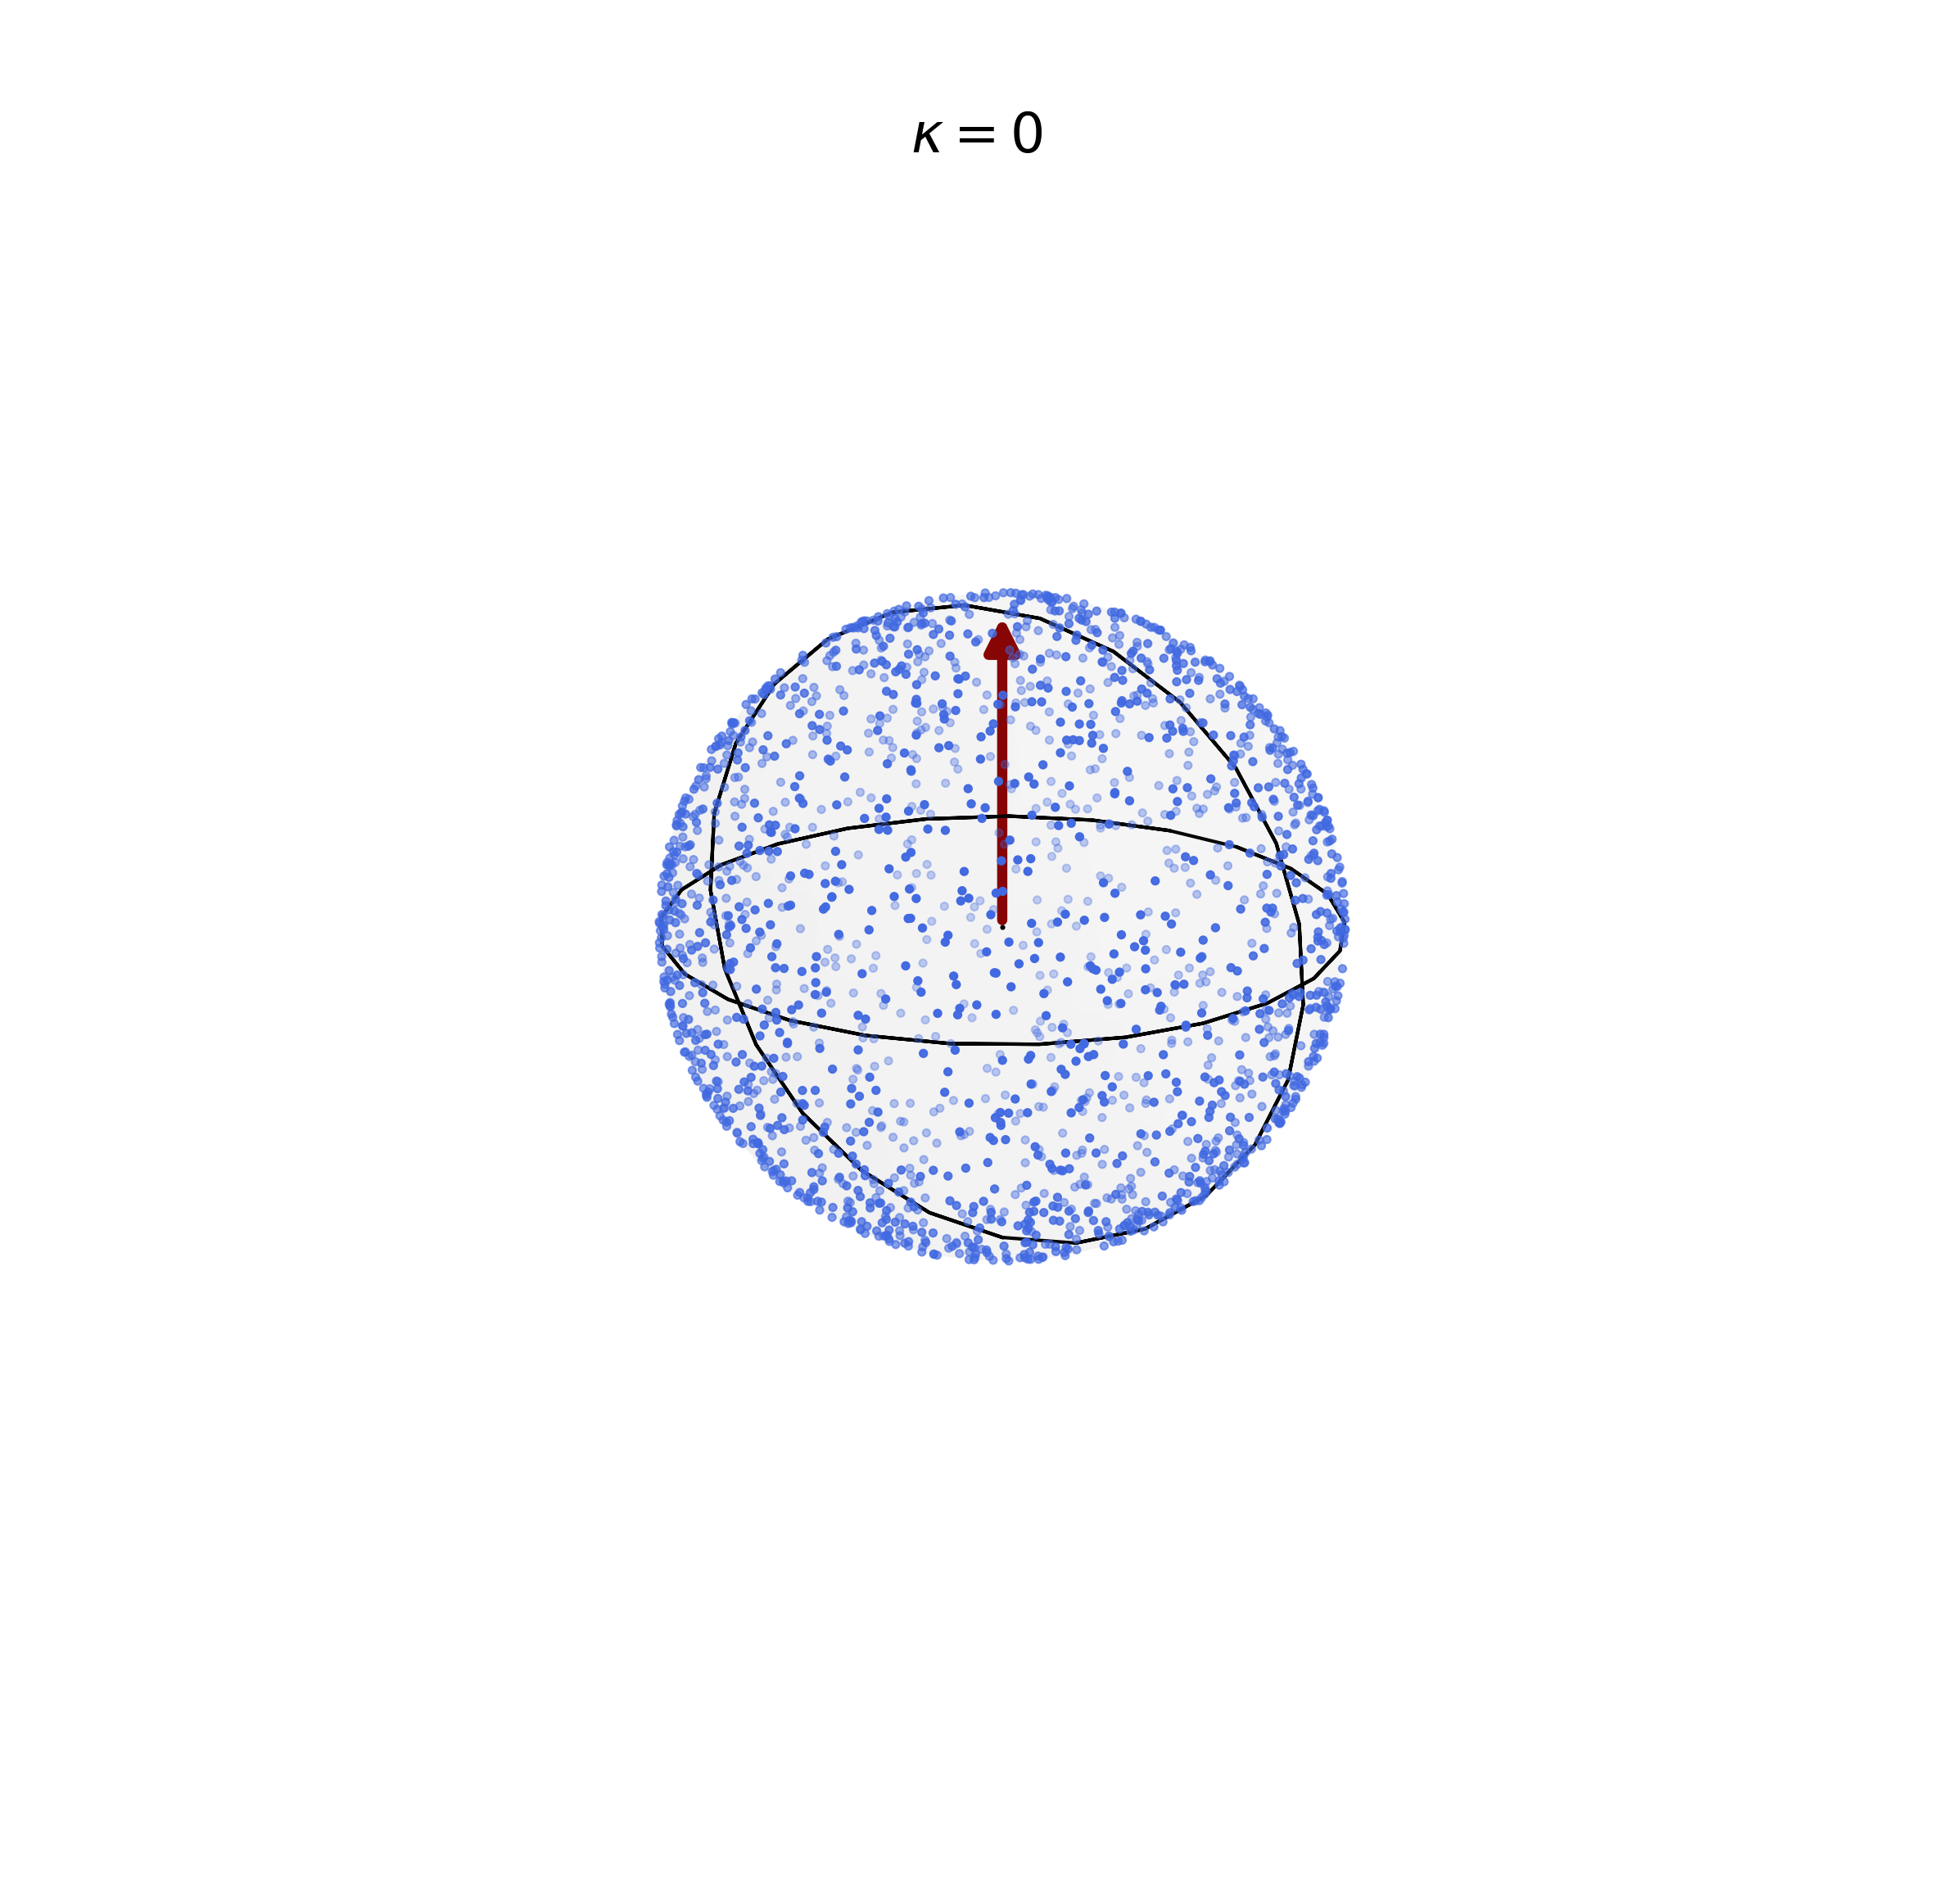

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

# Set 1
plot_3d_scatter(data1,ax, colour='royalblue', sz=1.)
plot_arrow(mu1,ax,colour="darkred")

# Labels 
ax.set_axis_off()
ax.set_xlabel('x',fontsize=fs)
ax.set_ylabel('y',fontsize=fs)
ax.set_zlabel('z',fontsize=fs)

# Viewing angle
ax.view_init(20,120)
ax.set_title('$\kappa=0$', fontsize=fs)
plt.show()




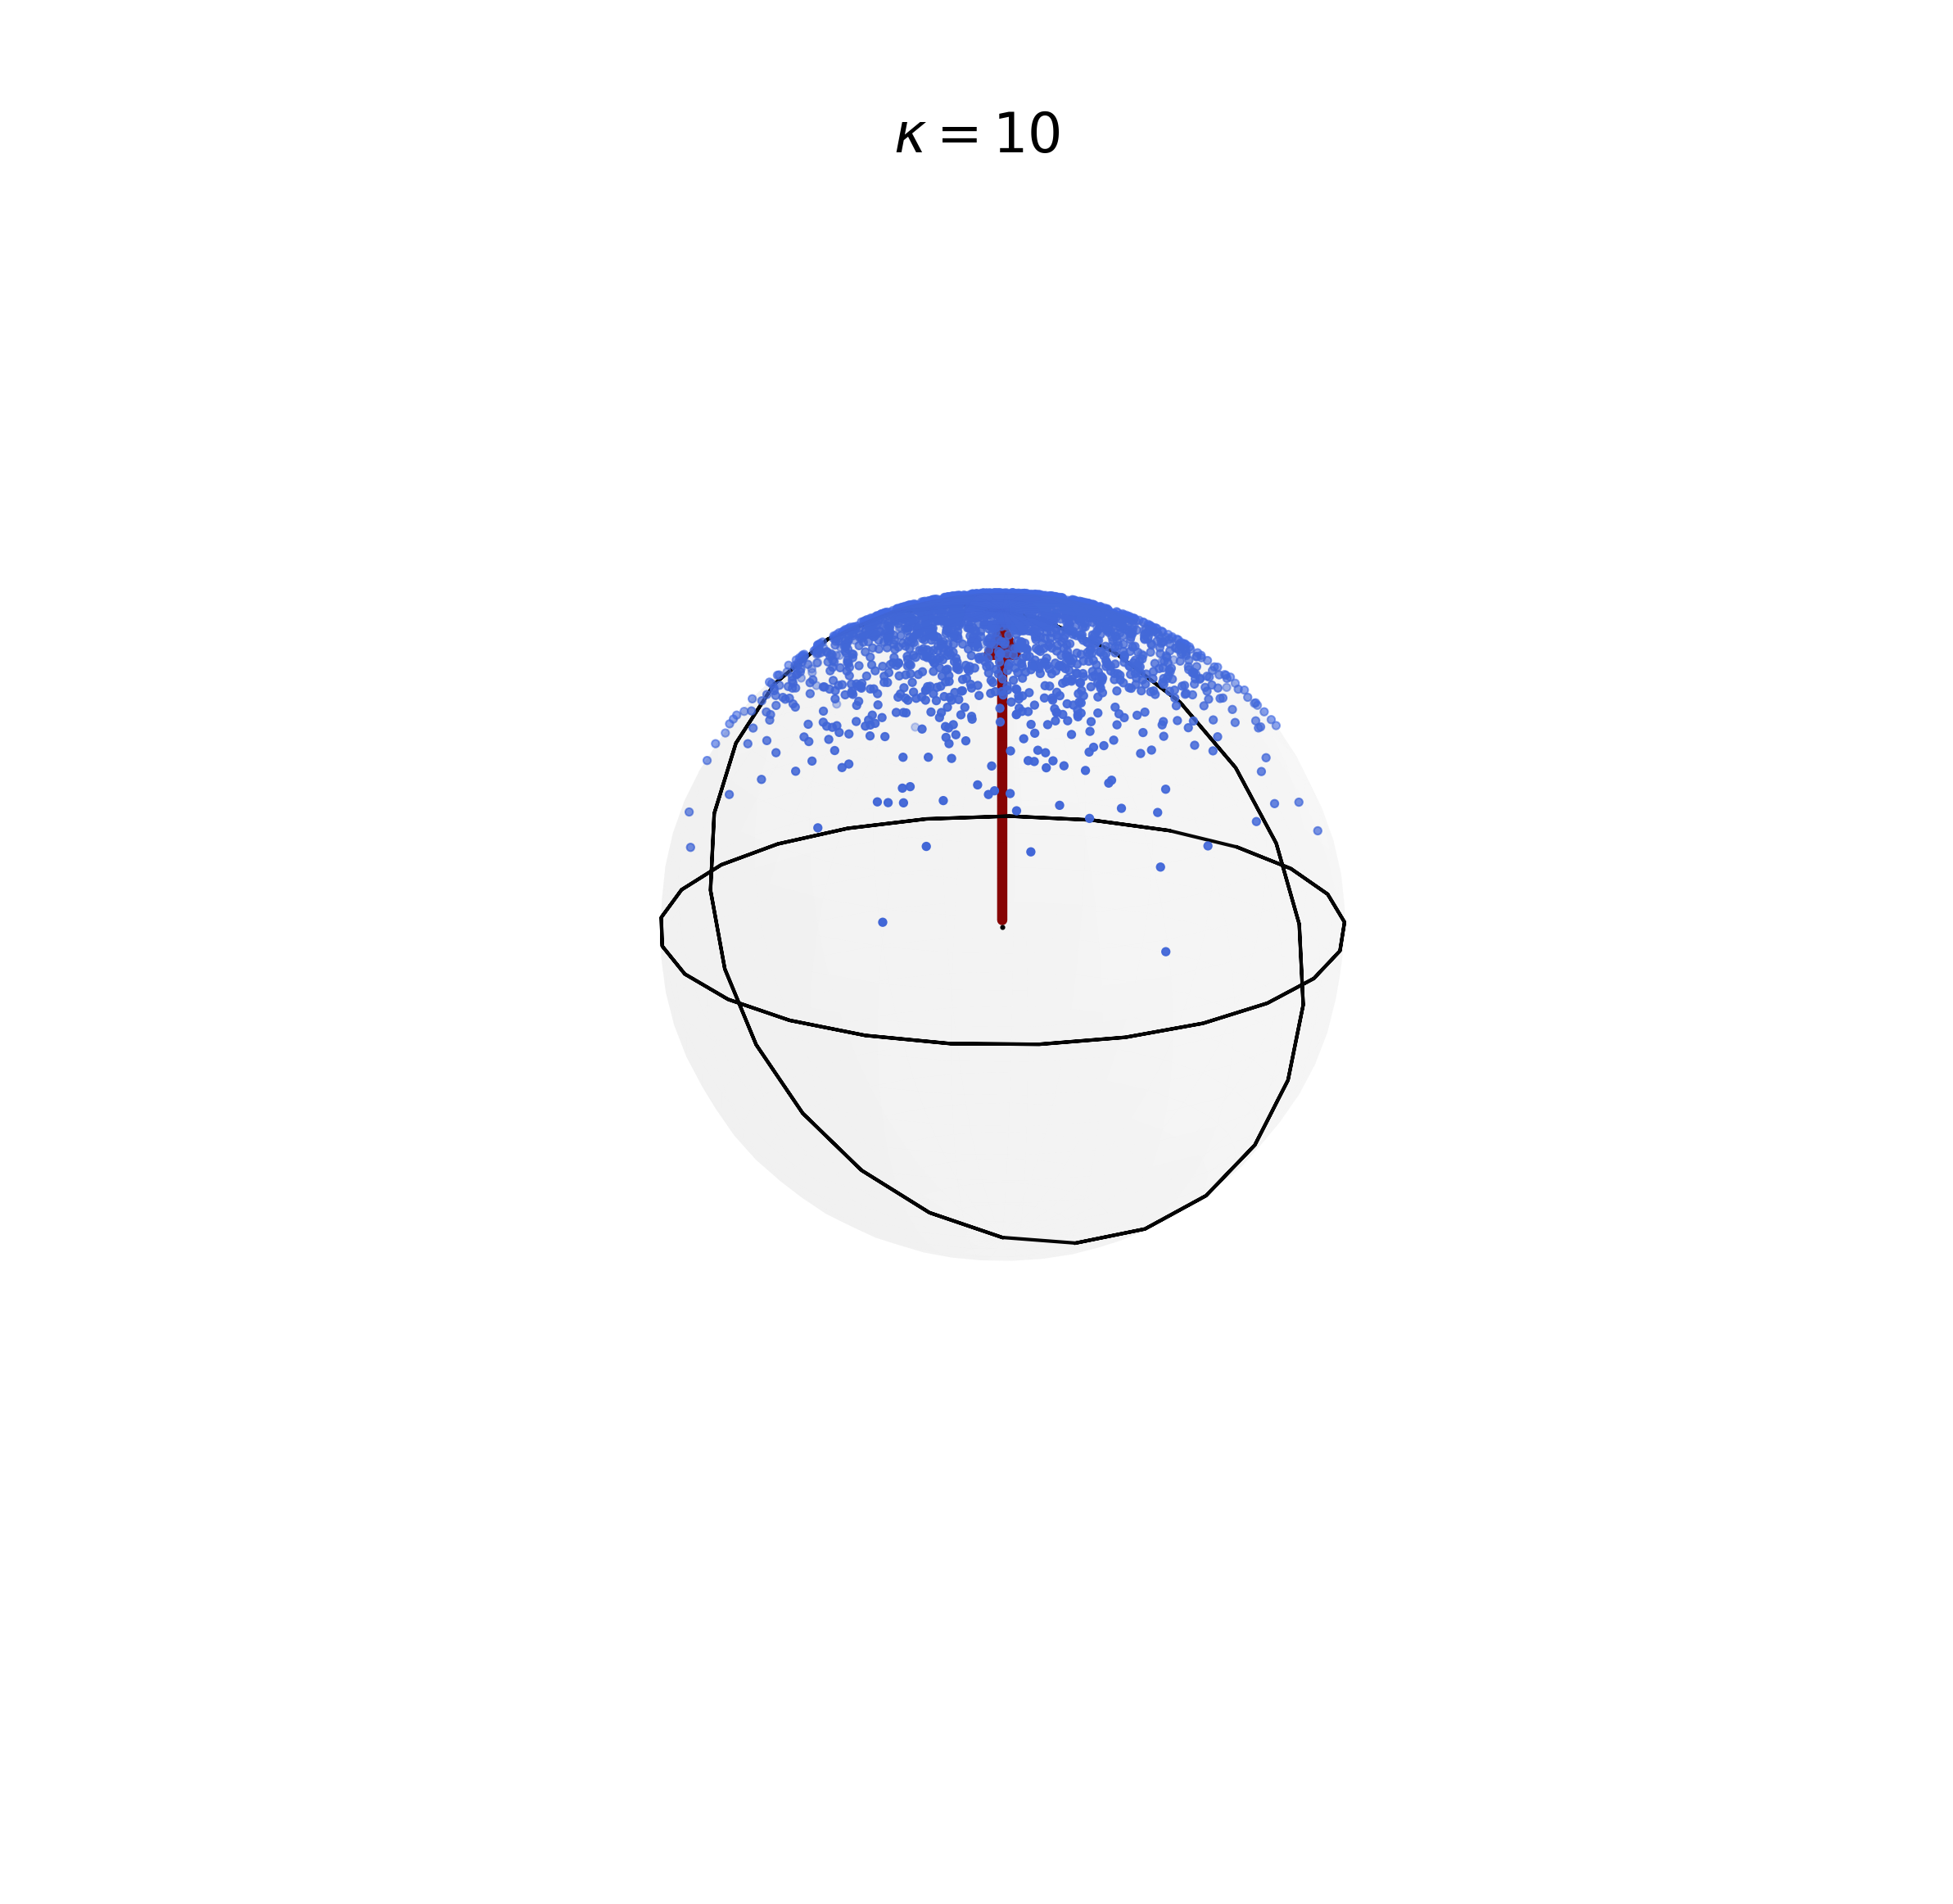

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

# Set 1
plot_3d_scatter(data2,ax, colour='royalblue', sz=1.)
plot_arrow(mu1,ax,colour="darkred")

# Labels 
ax.set_axis_off()
ax.set_xlabel('x',fontsize=fs)
ax.set_ylabel('y',fontsize=fs)
ax.set_zlabel('z',fontsize=fs)

# Viewing angle
ax.view_init(20,120)
ax.set_title('$\kappa=10$', fontsize=fs)
plt.show()


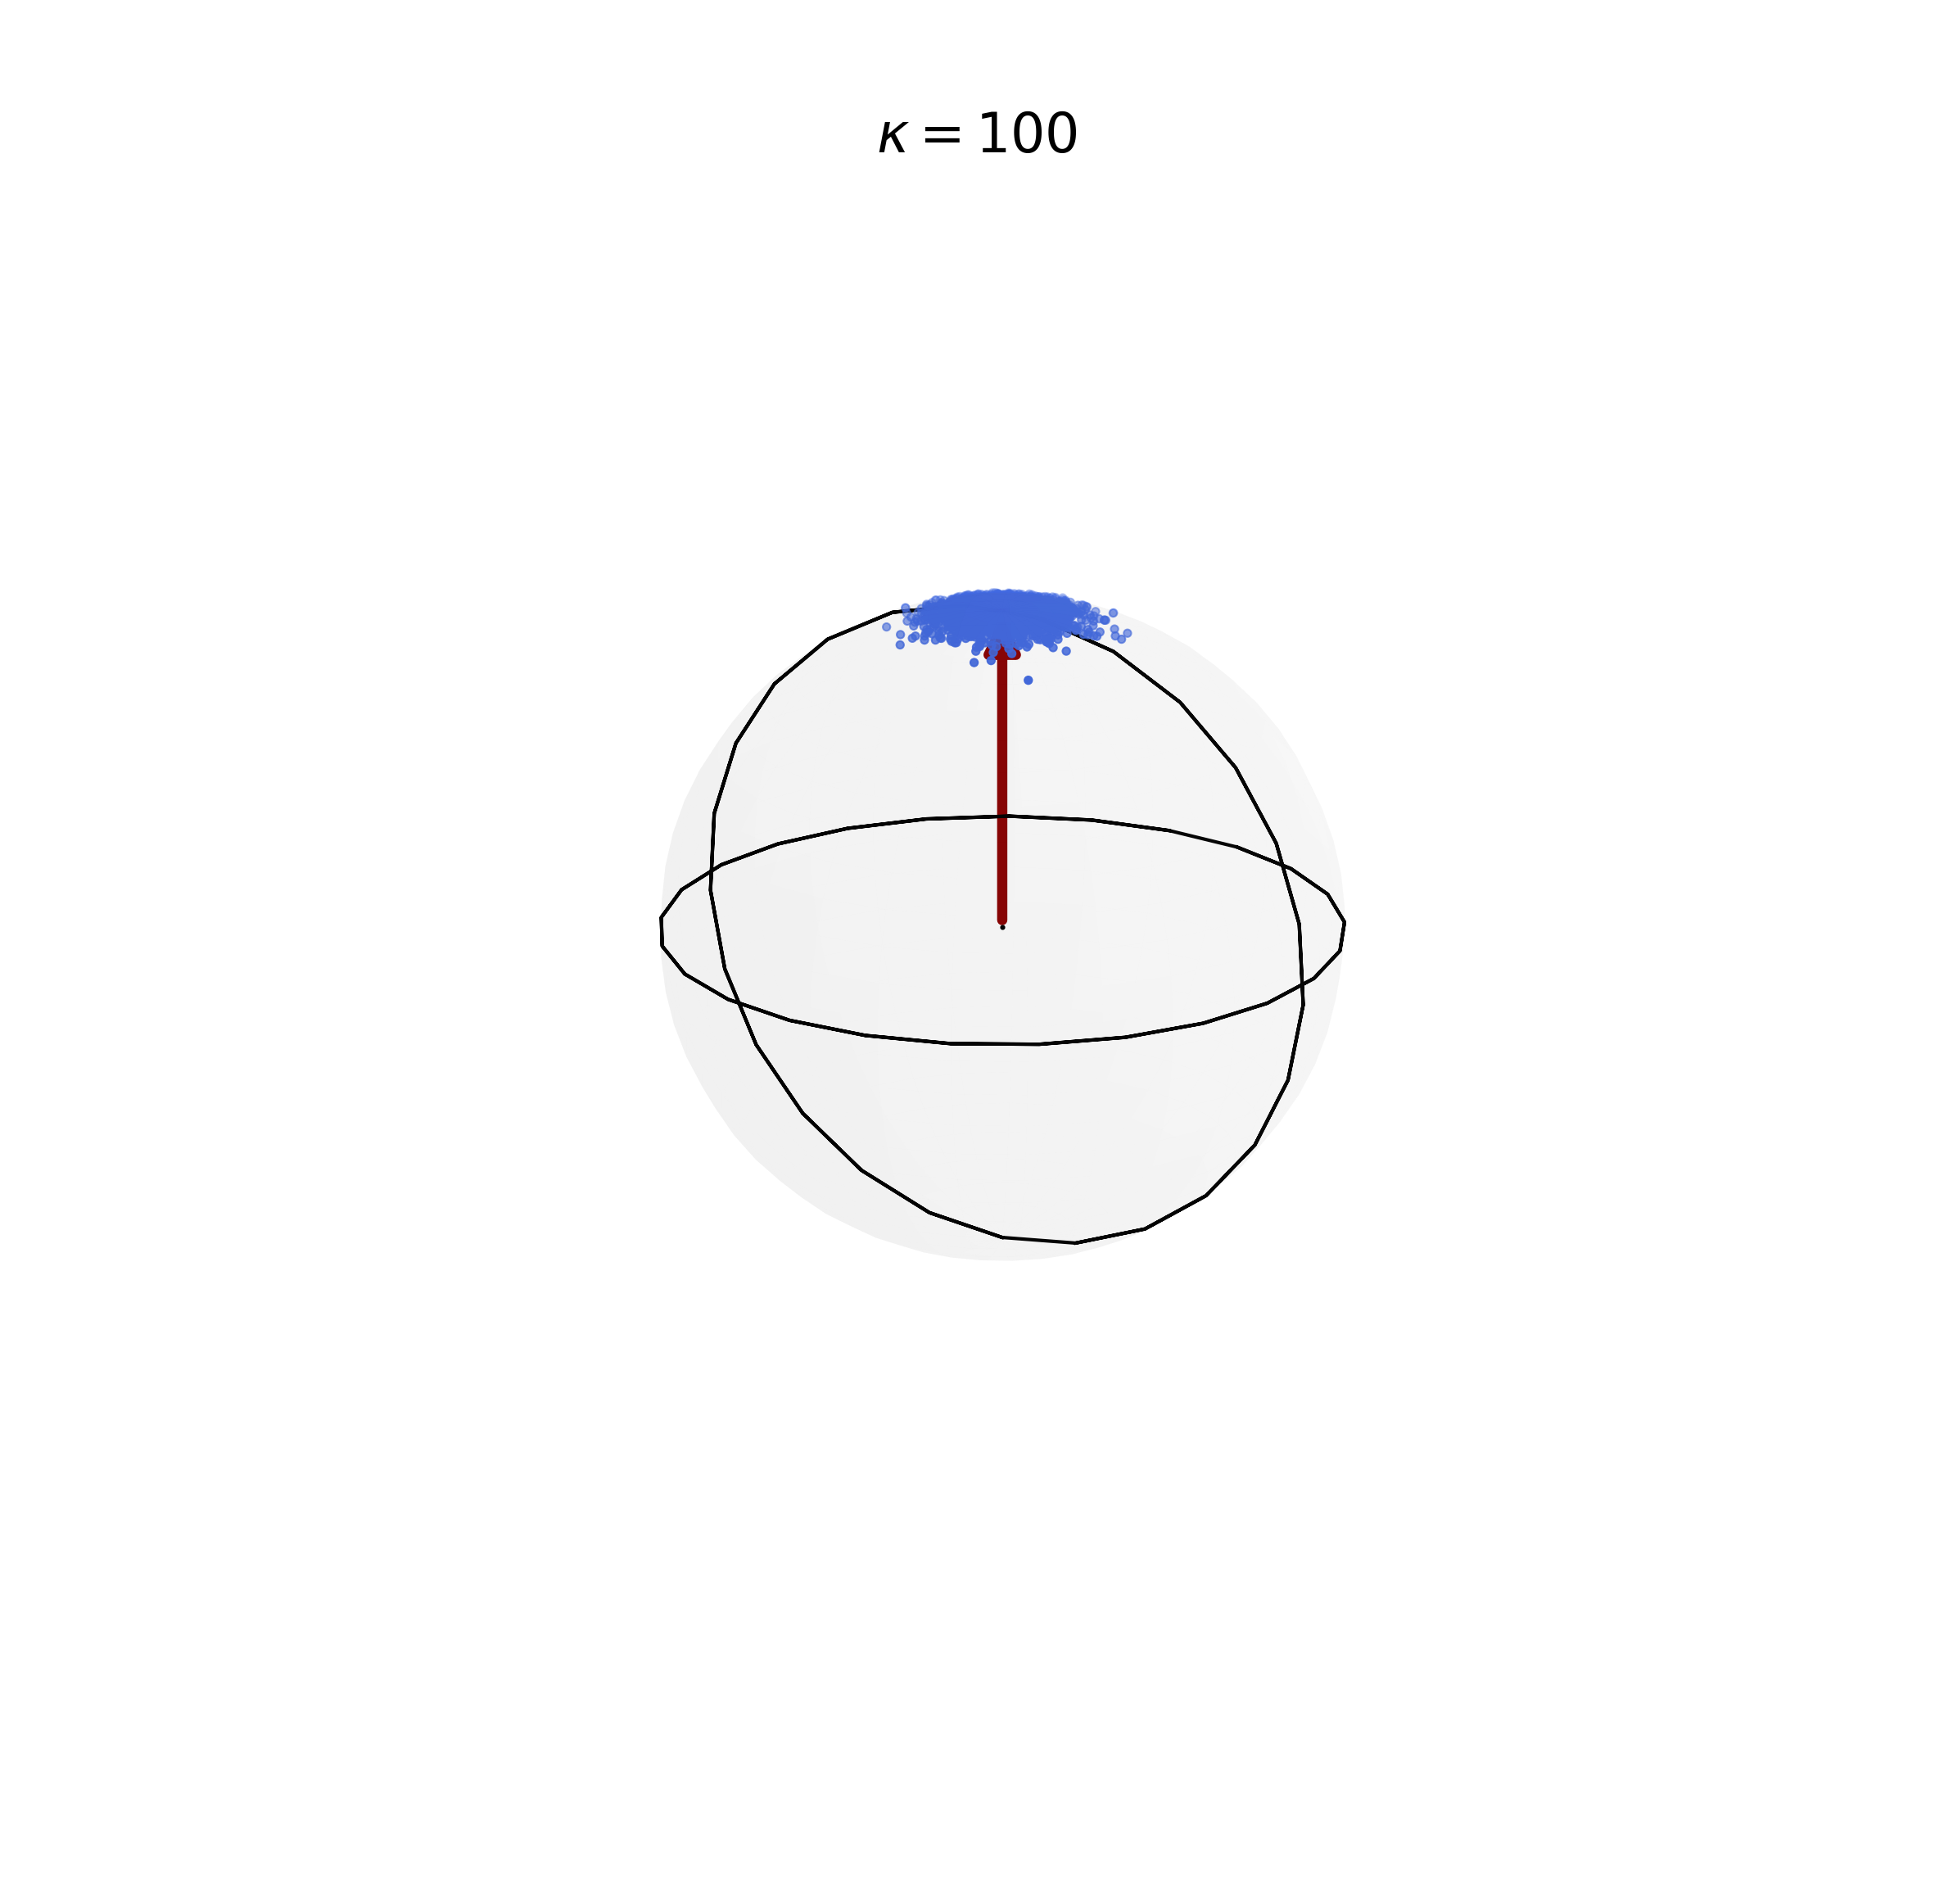

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

# Set 1
plot_3d_scatter(data3,ax, colour='royalblue', sz=1.)
plot_arrow(mu1,ax,colour="darkred")

# Labels 
ax.set_axis_off()
ax.set_xlabel('x',fontsize=fs)
ax.set_ylabel('y',fontsize=fs)
ax.set_zlabel('z',fontsize=fs)

# Viewing angle
ax.view_init(20,120)
ax.set_title('$\kappa=100$', fontsize=fs)
plt.show()


## References

Main reference: https://github.com/dlwhittenbury/von-Mises-Fisher-Sampling/blob/master/von-Mises-Fisher.ipynb